In [1]:
from iterativenn.nn_modules.MaskedLinear import MaskedLinear
import torch
import matplotlib.pylab as py

/home/rcpaffenroth/projects/iterativenn/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(1234)

Not needed, but keeping just for reference.  You can get this by using a normal Sequential.  Note, I might
do this since it seems a bit cleaner.

In [3]:
class SequentialIterative(torch.nn.Module):
    def __init__(self, model, iterations=1):
        super(SequentialIterative, self).__init__()
        self.model = model
        self.iterations = iterations

    def forward(self, x):
        for i in range(self.iterations):
            x = self.model(x)
        return x

We will need this for the non-linear version since we need different activation functions for different sections

In [4]:
class HeterogeneousActivation(torch.nn.Module):
    def __init__(self, activations, starts, ends):
        super(HeterogeneousActivation, self).__init__()
        self.activations = activations
        self.starts = starts
        self.ends = ends

    def forward(self, x):
        for activation, start, end in zip(self.activations, self.starts, self.ends):
            x[:, start:end] = activation(x[:, start:end])
        return x

In [5]:
# make a block matrix using pytorch hstack and vstack
def bmatrix(M):
    rows = []
    for r in M:
        rows += [torch.hstack(r)]
    return torch.vstack(rows)

In [6]:
X_size = 3
Y_size = 2
T_size = 10
data_size = 128


In [7]:
X = torch.randn(data_size, X_size)
W_true = torch.randn(Y_size, X_size)
Y = X @ W_true.T


Assume that random variables $X$ and $Y$ are linearly related, then there exists a matrix $W$ such that

$$
XW=Y\\
X^T X W = X^T Y \\
(X^T X)^{-1} X^T X W = (X^T X)^{-1} X^T Y \\
W = (X^T X)^{-1} X^T Y 
$$

where $X \in \mathbb{R}^{k \times n}$
$Y \in \mathbb{R}^{k \times m}$
and $W \in \mathbb{R}^{n \times m}$.

Generally, $X$ is a $n$ dimensional random variable, $Y$ is a $m$ dimensional random variable, and we have $k$ samples of each as training data.

Note, this is totally general.  I mean, if $X$ and $Y$ are not linearly related, then this will be first term of the Taylor series of a more general non-linear $f$ such that 

$$
f(X) = Y
$$

$$
W = 
\begin{bmatrix}
I_3 & 0 \\
W_{true} & 0 \\
\end{bmatrix}
$$

So, $W_{true} \in \mathbb{R}^{2 \times 3}$ and 
$W_{true}^T \in \mathbb{R}^{3 \times 3}$

$$
W = 
\begin{bmatrix}
I_3 & 0 \\
W_{true} & 0 \\
\end{bmatrix}
\begin{bmatrix}
X \\
R
\end{bmatrix}
=
\begin{bmatrix}
X \\
Y
\end{bmatrix}
$$

Note, this map is nilpotent, so the vector 

$$
\begin{bmatrix}
X \\
Y
\end{bmatrix}
$$

is a fixed point.

$$
W = 
\begin{bmatrix}
I_3 & 0 \\
W_{true} & 0 \\
\end{bmatrix}
\begin{bmatrix}
X \\
Y
\end{bmatrix}
=
\begin{bmatrix}
X \\
Y
\end{bmatrix}
$$

In [8]:
A = MaskedLinear(X_size+Y_size, X_size+Y_size, bias=False)
with torch.no_grad():
    A.weight_0 = torch.nn.Parameter(bmatrix([[torch.eye(X_size), torch.zeros(X_size, Y_size)],
                                             [W_true,            torch.zeros(Y_size, Y_size)]]))

    A.mask[:, :] = torch.zeros(X_size+Y_size, X_size+Y_size)

Sigma = HeterogeneousActivation([torch.nn.Identity(), torch.nn.Identity()], [0, X_size], [X_size, X_size+Y_size])
Iterate = torch.nn.Sequential(A, Sigma)
F = torch.nn.Sequential(Iterate, Iterate, Iterate, Iterate)


Should be 0, since we have initialized the model with the truth

In [9]:
Z = torch.concat([X, torch.zeros(data_size, Y_size)], dim=1)

assert torch.linalg.norm(F(Z)[:, X_size:(X_size+Y_size)]-Y)<1e-6

We can let the map grow

$$
W = 
\begin{bmatrix}
I_3 & 0 & 0\\
0 & 0 & 0\\
W_{true} & 0 & 0\\
\end{bmatrix}
$$

A classic way to do this would be "grow it from the middle".  This matches our current notation.

$$
W = 
\begin{bmatrix}
I_3 & 0 & 0\\
W_1 & 0 & 0\\
W_{true} & W_2 & 0\\
\end{bmatrix}
$$

However, for notational convenience, let's write this just a little differently by transposing the last two rows 

$$
W = 
\begin{bmatrix}
I_3 & 0 & 0\\
W_{true} & W_2 & 0\\
W_1 & 0 & 0\\
\end{bmatrix}
$$

and columns

$$
W = 
\begin{bmatrix}
I_3 & 0 & 0\\
W_{true} & 0 & W_2\\
W_1 & 0 & 0\\
\end{bmatrix}
$$

Now, the input and output rows are always at the same indices in the vector.

$$
\begin{bmatrix}
I_3 & 0 & 0\\
W_{true} & 0 & W_2\\
W_1 & 0 & 0\\
\end{bmatrix}
\begin{bmatrix}
x \\
y \\
h \\
\end{bmatrix}
$$

Let's double check

$$
\begin{bmatrix}
I_3 & 0 & 0\\
W_1 & 0 & 0\\
W_{true} & W_2 & 0\\
\end{bmatrix}
\begin{bmatrix}
x \\
h \\
y \\
\end{bmatrix}
=
\begin{bmatrix}
x \\
W_1 x \\
W_{true} x + W_2 h \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
I_3 & 0 & 0\\
W_{true} & 0 & W_2\\
W_1 & 0 & 0\\
\end{bmatrix}
\begin{bmatrix}
x \\
y \\
h \\
\end{bmatrix}
=
\begin{bmatrix}
x \\
W_{true} x + W_2 h \\
W_1 x \\
\end{bmatrix}
$$

Cool, math works :-)


Ok, the new notation is convenient, but we want to understand what is really means.

$$
W = 
\begin{bmatrix}
I_3 & 0 & 0\\
W_{true} & 0 & T_0\\
T_1 & T_2 & T_3\\
\end{bmatrix}
$$

$$
W = 
\begin{bmatrix}
I_3 & 0 & 0\\
W_{true} & T_0 & 0\\
T_1 & T_3 & T_2\\
\end{bmatrix}
$$

$$
W = 
\begin{bmatrix}
I_3 & 0 & 0\\
T_1 & T_3 & T_2\\
W_{true} & T_0 & 0\\
\end{bmatrix}
$$

Why the zeros?  The zeros in the top road mean that we don't affect the input.   The zero in the bottom row means that the output is a function of the input and the hidden layer, but not a function of the previous output.   I am not sure this is a good way to do it, but it is a way to do it.


Ok, that was a lot of work in changing the notation, but to what end?  Using the new notation it is clear how to grow the map with more unknowns.

$$
W = 
\begin{bmatrix}
I_3 & 0 & 0 & 0\\
W_{true} & 0 & T_0 & U_0\\
T_1 & T_2 & T_3 & U_1 \\
U_2 & U_3 & U_4 & U_5 \\
\end{bmatrix}
$$

So, for example, in the following case, adding $h_3$ does not change anything.

$$
\begin{bmatrix}
I_3 & 0 & 0 & 0 & 0\\
W_{true} & 0 & T_0 & U_0 & 0\\
T_1 & T_2 & T_3 & U_1 & 0\\
U_2 & U_3 & U_4 & U_5 & 0\\
0 & 0 & 0 & 0 & 0\\
\end{bmatrix}
\begin{bmatrix}
x \\
y \\
h_1 \\
h_2 \\
h_3 
\end{bmatrix}
$$

My imagination :-)


$$
W = 
\begin{bmatrix}
I_3 & 0 & 0 & 0\\
W_{true} & 0 & T_0 & U_0\\
T_1 & T_2 & T_3 & U_1 \\
U_2 & U_3 & U_4 & U_5 \\
\end{bmatrix}
\begin{bmatrix}
Eyes \\
Fingers \\
H_{lizard brain}\\
H_{monkey brain}
\end{bmatrix}
$$

In [10]:
A = MaskedLinear(X_size+Y_size+T_size, X_size+Y_size+T_size, bias=False)
with torch.no_grad():
    # The requires_grad=False is important, otherwise the gradient will be computed when we don't want it to.
    A.weight_0 = torch.nn.Parameter(bmatrix([[torch.eye(X_size),           torch.zeros(X_size, Y_size), torch.zeros(X_size, T_size)],
                                             [W_true,                      torch.zeros(Y_size, Y_size), torch.zeros(Y_size, T_size)],
                                             [torch.zeros(T_size, X_size), torch.zeros(T_size, Y_size), torch.zeros(T_size, T_size)]]
                                             ), requires_grad=False)

    A.mask[:, :] = bmatrix([[torch.zeros(X_size, X_size), torch.zeros(X_size, Y_size), torch.zeros(X_size, T_size)],
                            [torch.zeros(Y_size, X_size), torch.zeros(Y_size, Y_size), torch.ones(Y_size, T_size)],
                            [torch.ones(T_size, X_size),  torch.ones(T_size, Y_size),  torch.ones(T_size, T_size)]]
                        )

Sigma = HeterogeneousActivation([torch.nn.Identity(), torch.nn.Identity(), torch.nn.Sigmoid()], [0, X_size, X_size+Y_size], [X_size, X_size+Y_size, X_size+Y_size+T_size])
Iterate = torch.nn.Sequential(A, Sigma)
F = torch.nn.Sequential(Iterate, Iterate, Iterate, Iterate)


In [11]:
X_slice = slice(0, X_size)
Y_slice = slice(X_size, X_size+Y_size)
T_slice = slice(X_size+Y_size, X_size+Y_size+T_size)

In [12]:
Z = torch.concat([X, torch.zeros(data_size, Y_size), torch.zeros(data_size, T_size)], dim=1)
assert torch.linalg.norm(F(Z)[:, Y_slice]-Y)<1e-6

TRAIN!

In [13]:
import torch.optim as optim

criterion = torch.nn.MSELoss()


In [14]:
optimizer = optim.SGD(F.parameters(), lr=0.01, momentum=0.9)
epochs = 5
for i in range(epochs):
    optimizer.zero_grad()
    Zhat = F(Z)
    loss = torch.linalg.norm(Zhat[:, Y_slice]-Y)
    loss.backward()
    optimizer.step()
    

In [15]:
A.U

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0206, -0.0206, -0.0206,
         -0.0206, -0.0206, -0.0206, -0.0206, -0.0206, -0.0206, -0.0206],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0119, -0.0119, -0.0119,
         -0.0119, -0.0119, -0.0119, -0.0119, -0.0119, -0.0119, -0.0119],
        [ 0.0002,  0.0010,  0.0006,  0.0001, -0.0012, -0.0035, -0.0035, -0.0035,
         -0.0035, -0.0035, -0.0035, -0.0035, -0.0035, -0.0035, -0.0035],
        [ 0.0002,  0.0010,  0.0006,  0.0001, -0.0012, 

# Let's make it a bit harder by making $Y$ non-linear

In [16]:
Y_orig = 1.0*Y
Y = Y_orig + (Y_orig**2+1.123)*0.1
W_init = (torch.inverse(X.T @ X)@X.T@Y).T

# Test with normal initialization

In [17]:
A = MaskedLinear(X_size+Y_size+T_size, X_size+Y_size+T_size, bias=False)
with torch.no_grad():
    # The requires_grad=False is important, otherwise the gradient will be computed when we don't want it to.
    A.weight_0 = torch.nn.Parameter(bmatrix([[torch.eye(X_size),           torch.zeros(X_size, Y_size), torch.zeros(X_size, T_size)],
                                             [W_init,                      torch.zeros(Y_size, Y_size), torch.zeros(Y_size, T_size)],
                                             [torch.zeros(T_size, X_size), torch.zeros(T_size, Y_size), torch.zeros(T_size, T_size)]]
                                             ), requires_grad=False)

    A.mask[:, :] = bmatrix([[torch.zeros(X_size, X_size), torch.zeros(X_size, Y_size), torch.zeros(X_size, T_size)],
                            [torch.zeros(Y_size, X_size), torch.zeros(Y_size, Y_size), torch.ones(Y_size, T_size)],
                            [torch.ones(T_size, X_size),  torch.ones(T_size, Y_size),  torch.ones(T_size, T_size)]]
                        )

Sigma = HeterogeneousActivation([torch.nn.Identity(), torch.nn.Identity(), torch.nn.Sigmoid()], [0, X_size, X_size+Y_size], [X_size, X_size+Y_size, X_size+Y_size+T_size])
Iterate = torch.nn.Sequential(A, Sigma)
F = torch.nn.Sequential(Iterate, Iterate, Iterate, Iterate)

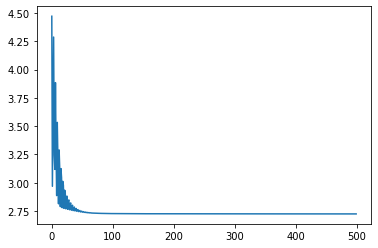

In [18]:
optimizer = optim.SGD(F.parameters(), lr=0.01, momentum=0.9)
epochs = 500
good_losses = []
for i in range(epochs):
    optimizer.zero_grad()
    Zhat = F(Z)
    loss = torch.linalg.norm(Zhat[:, Y_slice]-Y)
    good_losses.append(float(loss))
    loss.backward()
    optimizer.step()
py.plot(good_losses)


In [19]:
A.U

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0648,  0.0648,  0.0648,
          0.0648,  0.0648,  0.0648,  0.0648,  0.0648,  0.0648,  0.0648],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0346,  0.0346,  0.0346,
          0.0346,  0.0346,  0.0346,  0.0346,  0.0346,  0.0346,  0.0346],
        [ 0.0221,  0.1927,  0.1035,  0.1125, -0.1567, -0.0687, -0.0687, -0.0687,
         -0.0687, -0.0687, -0.0687, -0.0687, -0.0687, -0.0687, -0.0687],
        [ 0.0221,  0.1927,  0.1035,  0.1125, -0.1567, 

# $Y$ non-linear and loss every iteration

In [20]:
A = MaskedLinear(X_size+Y_size+T_size, X_size+Y_size+T_size, bias=False)
with torch.no_grad():
    # The requires_grad=False is important, otherwise the gradient will be computed when we don't want it to.
    A.weight_0 = torch.nn.Parameter(bmatrix([[torch.eye(X_size),           torch.zeros(X_size, Y_size), torch.zeros(X_size, T_size)],
                                             [W_init,                      torch.zeros(Y_size, Y_size), torch.zeros(Y_size, T_size)],
                                             [torch.zeros(T_size, X_size), torch.zeros(T_size, Y_size), torch.zeros(T_size, T_size)]]
                                             ), requires_grad=False)

    A.mask[:, :] = bmatrix([[torch.zeros(X_size, X_size), torch.zeros(X_size, Y_size), torch.zeros(X_size, T_size)],
                            [torch.zeros(Y_size, X_size), torch.zeros(Y_size, Y_size), torch.ones(Y_size, T_size)],
                            [torch.ones(T_size, X_size),  torch.ones(T_size, Y_size),  torch.ones(T_size, T_size)]]
                        )

Sigma = HeterogeneousActivation([torch.nn.Identity(), torch.nn.Identity(), torch.nn.Sigmoid()], [0, X_size, X_size+Y_size], [X_size, X_size+Y_size, X_size+Y_size+T_size])
Iterate = torch.nn.Sequential(A, Sigma)
F = torch.nn.Sequential(Iterate)

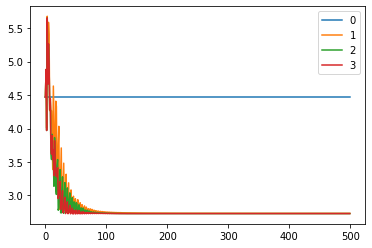

In [21]:
optimizer = optim.SGD(F.parameters(), lr=0.01, momentum=0.9)
epochs = 500
good_multiple_losses = [[],[],[],[]]
for i in range(epochs):
    optimizer.zero_grad()
    total_loss = 0
    Zhat = F(Z)
    loss = torch.linalg.norm(Zhat[:, Y_slice]-Y)
    total_loss += loss
    good_multiple_losses[0].append(float(loss))

    for i in range(1,4):
        Zhat = F(Zhat)
        loss = torch.linalg.norm(Zhat[:, Y_slice]-Y)
        total_loss += loss
        good_multiple_losses[i].append(float(loss))

    total_loss.backward()
    optimizer.step()
for k in range(4):
    py.plot(good_multiple_losses[k])
py.legend(['0','1','2','3'])

In [22]:
A.U

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0574,  0.0574,  0.0574,
          0.0574,  0.0574,  0.0574,  0.0574,  0.0572,  0.0572,  0.0572],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0305,  0.0305,  0.0305,
          0.0305,  0.0305,  0.0305,  0.0305,  0.0309,  0.0309,  0.0309],
        [ 0.0335,  0.2995,  0.1794,  0.0152, -0.0386, -0.0144, -0.0144, -0.0144,
         -0.0144, -0.0144, -0.0144, -0.0144, -0.0144, -0.0144, -0.0144],
        [ 0.0335,  0.2995,  0.1794,  0.0152, -0.0386, 

# Let's try with everything trainable and random initialization

In [23]:
A = MaskedLinear(X_size+Y_size+T_size, X_size+Y_size+T_size, bias=False)
with torch.no_grad():
    s = 0.01
    # The requires_grad=False is important, otherwise the gradient will be computed when we don't want it to.
    A.weight_0 = torch.nn.Parameter(bmatrix([[s*torch.randn(X_size, X_size), s*torch.randn(X_size, Y_size), s*torch.randn(X_size, T_size)],
                                             [s*torch.randn(Y_size, X_size), s*torch.randn(Y_size, Y_size), s*torch.randn(Y_size, T_size)],
                                             [s*torch.randn(T_size, X_size), s*torch.randn(T_size, Y_size), s*torch.randn(T_size, T_size)]]
                                             ), requires_grad=False)

    A.mask[:, :] = bmatrix([[torch.ones(X_size, X_size), torch.ones(X_size, Y_size), torch.ones(X_size, T_size)],
                            [torch.ones(Y_size, X_size), torch.ones(Y_size, Y_size), torch.ones(Y_size, T_size)],
                            [torch.ones(T_size, X_size), torch.ones(T_size, Y_size), torch.ones(T_size, T_size)]]
                        )

Sigma = HeterogeneousActivation([torch.nn.Identity(), torch.nn.Identity(), torch.nn.Sigmoid()], [0, X_size, X_size+Y_size], [X_size, X_size+Y_size, X_size+Y_size+T_size])
Iterate = torch.nn.Sequential(A, Sigma)
F = torch.nn.Sequential(Iterate, Iterate, Iterate, Iterate)

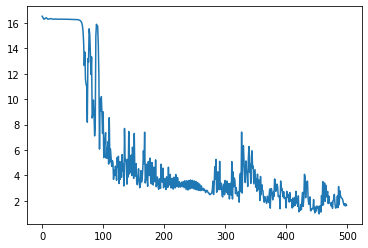

In [24]:
optimizer = optim.SGD(F.parameters(), lr=0.01, momentum=0.9)
epochs = 500
bad_losses = []
for i in range(epochs):
    optimizer.zero_grad()
    Zhat = F(Z)
    loss = torch.linalg.norm(Zhat[:, Y_slice]-Y)
    bad_losses.append(float(loss))
    loss.backward()
    optimizer.step()
py.plot(bad_losses)

In [25]:
A.U

Parameter containing:
tensor([[ 1.1507e+00, -3.5306e-01, -4.3638e-01, -2.8239e-01, -8.3165e-01,
         -2.7351e-01, -1.5954e-01,  5.6647e-01,  4.1584e-01, -1.8306e-01,
         -1.5492e-01,  1.1442e-01,  8.0808e-01, -2.1012e-01, -2.9033e-02],
        [-5.2749e-01, -4.1529e-01,  1.1745e-01, -2.5295e-01,  7.4323e-01,
         -1.5112e-01, -1.3574e-01,  9.1878e-02, -3.5453e-02, -1.5271e-01,
         -1.3720e-01,  1.6310e-01,  6.4773e-02, -1.4535e-01, -1.3206e-01],
        [-1.4208e-01, -7.7631e-01,  3.6102e-02, -2.3891e-01,  5.9331e-01,
          9.4496e-03,  6.9127e-02,  1.0538e-01,  1.4050e-01,  2.1101e-02,
          4.6111e-02,  7.1887e-02,  1.5509e-01, -2.2278e-02,  8.5295e-02],
        [ 3.0893e-01,  2.1698e-01,  3.2900e-01, -9.7766e-01,  2.6995e-01,
          4.2737e-01,  6.0576e-01, -1.0466e+00,  2.0514e+00,  3.2790e-01,
          4.7994e-01, -6.3176e-01, -1.3521e+00, -4.2576e-02,  5.6460e-01],
        [ 1.7446e-01, -3.6674e-01,  2.2861e-02,  3.5033e-01, -1.8513e-01,
         -3.

# Initialize correctly, but all trainable

In [26]:
A = MaskedLinear(X_size+Y_size+T_size, X_size+Y_size+T_size, bias=False)
with torch.no_grad():
    s = 0.01
    # The requires_grad=False is important, otherwise the gradient will be computed when we don't want it to.
    A.weight_0 = torch.nn.Parameter(bmatrix([[torch.eye(X_size),           torch.zeros(X_size, Y_size), torch.zeros(X_size, T_size)],
                                             [W_init,                      torch.zeros(Y_size, Y_size), torch.zeros(Y_size, T_size)],
                                             [torch.zeros(T_size, X_size), torch.zeros(T_size, Y_size), torch.zeros(T_size, T_size)]]
                                             ), requires_grad=False)

    A.mask[:, :] = bmatrix([[torch.ones(X_size, X_size), torch.ones(X_size, Y_size), torch.ones(X_size, T_size)],
                            [torch.ones(Y_size, X_size), torch.ones(Y_size, Y_size), torch.ones(Y_size, T_size)],
                            [torch.ones(T_size, X_size), torch.ones(T_size, Y_size), torch.ones(T_size, T_size)]]
                        )

Sigma = HeterogeneousActivation([torch.nn.Identity(), torch.nn.Identity(), torch.nn.Sigmoid()], [0, X_size, X_size+Y_size], [X_size, X_size+Y_size, X_size+Y_size+T_size])
Iterate = torch.nn.Sequential(A, Sigma)
F = torch.nn.Sequential(Iterate, Iterate, Iterate, Iterate)

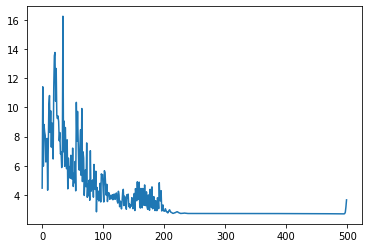

In [27]:
optimizer = optim.SGD(F.parameters(), lr=0.01, momentum=0.9)
epochs = 500
init_all_train_losses = []
for i in range(epochs):
    optimizer.zero_grad()
    Zhat = F(Z)
    loss = torch.linalg.norm(Zhat[:, Y_slice]-Y)
    init_all_train_losses.append(float(loss))
    loss.backward()
    optimizer.step()
py.plot(init_all_train_losses)

In [28]:
A.U

Parameter containing:
tensor([[-1.6332,  0.5382,  0.2315, -0.4964, -0.4608,  0.1001,  0.1001,  0.1001,
          0.1001,  0.1001,  0.1001,  0.1001,  0.1001,  0.1001,  0.1001],
        [ 0.1692,  0.2975, -0.3049, -0.2046, -0.0246, -0.0368, -0.0368, -0.0368,
         -0.0368, -0.0368, -0.0368, -0.0368, -0.0368, -0.0368, -0.0368],
        [-0.3112, -0.2291, -1.1611,  0.1486,  0.0124, -0.0110, -0.0110, -0.0110,
         -0.0110, -0.0110, -0.0110, -0.0110, -0.0110, -0.0110, -0.0110],
        [-0.4366, -0.4397, -0.3484, -0.8511, -0.6687,  0.1144,  0.1144,  0.1144,
          0.1144,  0.1144,  0.1144,  0.1144,  0.1144,  0.1144,  0.1144],
        [-0.3002, -0.0573,  0.0834,  0.6781, -0.5540,  0.1513,  0.1513,  0.1513,
          0.1513,  0.1513,  0.1513,  0.1513,  0.1513,  0.1513,  0.1513],
        [ 0.2623,  0.1036,  0.1062,  0.0232, -0.0490, -0.0909, -0.0909, -0.0909,
         -0.0909, -0.0909, -0.0909, -0.0909, -0.0909, -0.0909, -0.0909],
        [ 0.2623,  0.1036,  0.1062,  0.0232, -0.0490, 

# Compare them

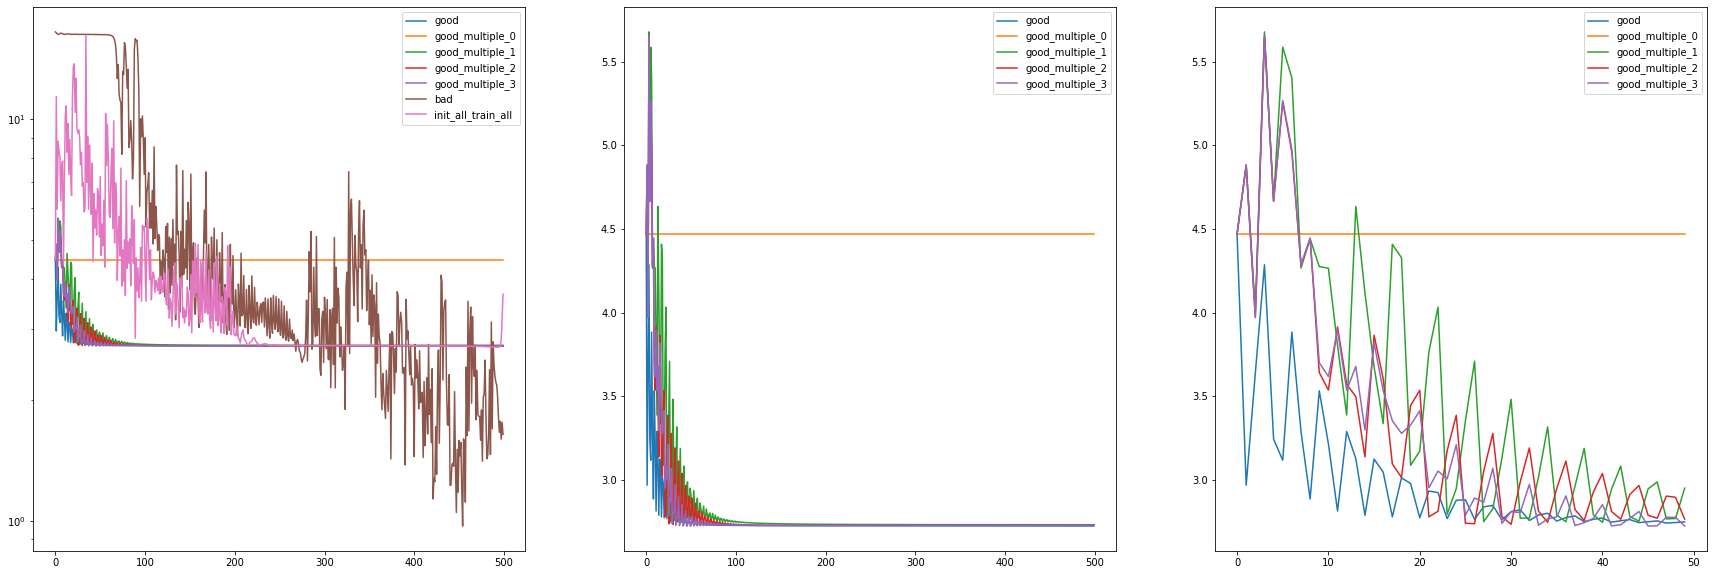

In [29]:
_,ax = py.subplots(ncols=3, figsize=(30,10))
ax[0].semilogy(good_losses)
ax[0].semilogy(good_multiple_losses[0])
ax[0].semilogy(good_multiple_losses[1])
ax[0].semilogy(good_multiple_losses[2])
ax[0].semilogy(good_multiple_losses[3])
ax[0].semilogy(bad_losses)
ax[0].semilogy(init_all_train_losses)
ax[0].legend(['good', 'good_multiple_0', 'good_multiple_1', 'good_multiple_2', 'good_multiple_3', 'bad', 'init_all_train_all'])

ax[1].plot(good_losses)
ax[1].plot(good_multiple_losses[0])
ax[1].plot(good_multiple_losses[1])
ax[1].plot(good_multiple_losses[2])
ax[1].plot(good_multiple_losses[3])
ax[1].legend(['good', 'good_multiple_0', 'good_multiple_1', 'good_multiple_2', 'good_multiple_3'])

ax[2].plot(good_losses[:50])
ax[2].plot(good_multiple_losses[0][:50])
ax[2].plot(good_multiple_losses[1][:50])
ax[2].plot(good_multiple_losses[2][:50])
ax[2].plot(good_multiple_losses[3][:50])
ax[2].legend(['good', 'good_multiple_0', 'good_multiple_1', 'good_multiple_2', 'good_multiple_3'])
